# Отток клиентов

Из Банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


__1. Знакомство с данными__ 

Загрузили данные. Далее изучим их, посмотрим на баланс классов, проверим наличие дубликатов и пропусков, при необходимости исправим проблемы, посмотрим на распределение признаков и возможные "выбросы".

Сразу заметили. что столбец, он же признак, RowNumber - следует удалить, т.к. никакой значимости он не несет и будет путать модель при обучении.

In [4]:
df = df.drop('RowNumber', axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Видим несбалансированность классов. "0" - 80% и "ушедших" (причина не уточняется) - 20%.

In [7]:
df.duplicated().sum()

0

Дубликатов нет.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


Имеем пропуски в данных. Tenure - количество недвижимости - заполнено на 90%.

Подумаем - как можем их заполнить:

1. Запросить у ответственного лица данные.

2. Удалить строки с пропусками.

3. Попытаться заполнить самостоятельно.

In [9]:
len(df['Surname'].unique())

2932

Количесвто уникалиных фамилий - 2932. Может ли это нам помочь? Можем ли мы взять заполненные данные у однофамильцев?

In [10]:
familiar = df.pivot_table(index=['Surname', 'Tenure'], values='Age')

In [11]:
familiar.tail(10)

Age
Surname  Tenure      
Zotova   1.0     38.0
Zox      3.0     48.0
Zubarev  6.0     26.0
         9.0     43.0
Zubareva 1.0     42.0
Zuev     1.0     39.0
Zuyev    8.0     39.0
         9.0     53.0
Zuyeva   1.0     32.0
         5.0     41.0

Давайте возьмём одну фамилию, к примеру Yin, и посмотрим на данные

In [12]:
df.loc[df.loc[:,'Surname'] == 'Yin']

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
48,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
458,15707362,Yin,514,Germany,Male,43,1.0,95556.31,1,0,1,199273.98,1
725,15672692,Yin,787,France,Female,42,10.0,145988.65,2,1,1,79510.37,0
1335,15576683,Yin,568,Spain,Female,43,9.0,0.00,1,1,0,125870.79,1
1677,15801767,Yin,784,Spain,Female,40,8.0,0.00,2,1,0,108891.30,0
3553,15626612,Yin,741,Spain,Male,40,4.0,104784.23,1,1,0,135163.76,1
3846,15737354,Yin,554,France,Female,48,7.0,0.00,2,1,1,63708.07,0
4611,15710553,Yin,555,Germany,Male,48,3.0,142055.41,2,0,1,79134.78,0
5529,15812647,Yin,691,France,Male,34,8.0,133936.04,2,1,0,91359.79,0
7361,15586479,Yin,692,France,Female,36,4.0,0.00,1,1,0,185580.89,1


In [13]:
len(df['CustomerId'].unique())

10000

Давайте посмотрим есть ли некоторая корреляция между Tenure и EstimatedSalary

In [14]:
df.corr()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.006248,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


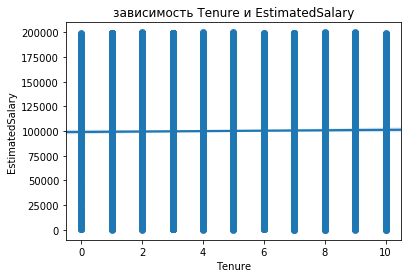

In [15]:
seaborn.regplot(x='Tenure', y='EstimatedSalary', data=df)
plt.title("зависимость Tenure и EstimatedSalary"); 
plt.xlabel("Tenure")
plt.ylabel("EstimatedSalary")
plt.show()

Метод corr(), а также и визуализация графика, однозначно дают понять, что связи нет и заполнить пропуски исходя из уровня зар.платы - совершенно необосновано.

Уникальных ID - 10000, то есть это действительно однофамильцы. И действительно, если посмотрим на таблицу выше, то увидим, что люди с аналогичной фамилией живут в разных странах, это люди разного пола и возраста с разной банковской активностью. 

Таким образом взять информацию у объекта с аналогичной фамилией станет ошибкой. Также как и заполнить пропуск медианой исходя из страны проживания, пола или возраста, это будет крайне субъективно и не ясно насколько далеко от истины. Зависимости зар.платы и количества недвижимости - также проследить не удалось.

Значит остается 2 выхода:
1. Запросить у ответственного лица данные (скачать с Kaggle заполненные данные в случае предполагаемого ответа, предположим, что ответа не поступит и вынуждены справляться самостоятельно).
2. Удалить строки с пропусками.

Предлогаю поступить так: сохранить данные в новый датафрейм, но без признака 'Tenure' и работать с 10000 объектами, а во втором  - удалить пропуски. Обучить модели на обоих датафреймах и посмотреть на их продуктивность, заодно и поймём насколько важен для предсказания признак - количество недвижимости.



In [16]:
without_tenure = df.drop('Tenure', axis=1)

In [17]:
without_tenure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [18]:
with_tenure = df.dropna().reset_index(drop
= True)

In [19]:
with_tenure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 13 columns):
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 923.4+ KB


In [20]:
with_tenure.tail(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9081,15605622,McMillan,841,Spain,Male,28,4.0,0.00,2,1,1,179436.60,0
9082,15798964,Nkemakonam,714,Germany,Male,33,3.0,35016.60,1,1,0,53667.08,0
9083,15769959,Ajuluchukwu,597,France,Female,53,4.0,88381.21,1,1,0,69384.71,1
9084,15657105,Chukwualuka,726,Spain,Male,36,2.0,0.00,1,1,0,195192.40,0
9085,15569266,Rahman,644,France,Male,28,7.0,155060.41,1,1,0,29179.52,0
9086,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9087,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9088,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9089,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9090,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [21]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Text(0, 0.5, 'количество человек')

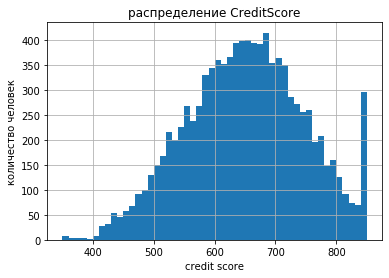

In [22]:
df['CreditScore'].hist(bins=50)
plt.title('распределение CreditScore')
plt.xlabel('credit score')
plt.ylabel('количество человек')

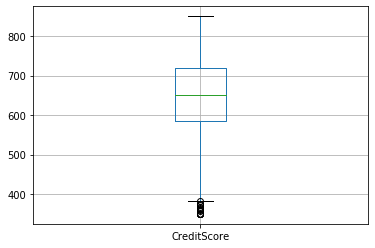

In [23]:
df.boxplot('CreditScore')

In [24]:
df['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

In [25]:
df.loc[df['CreditScore'] < 400]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
942,15804586,Lin,376,France,Female,46,NaN,0.00,1,1,0,157333.69,1
1193,15779947,Thomas,363,Spain,Female,28,6.0,146098.43,3,1,0,100615.14,1
1201,15651052,McMasters,399,Germany,Male,46,2.0,127655.22,1,1,0,139994.68,1
1405,15612494,Panicucci,359,France,Female,44,NaN,128747.69,1,1,0,146955.71,1
1631,15685372,Azubuike,350,Spain,Male,54,1.0,152677.48,1,1,1,191973.49,1
1838,15758813,Campbell,350,Germany,Male,39,0.0,109733.20,2,0,0,123602.11,1
1962,15692416,Aikenhead,358,Spain,Female,52,8.0,143542.36,3,1,0,141959.11,1
2473,15679249,Chou,351,Germany,Female,57,4.0,163146.46,1,1,0,169621.69,1
2579,15597896,Ozoemena,365,Germany,Male,30,0.0,127760.07,1,1,0,81537.85,1


In [26]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

В нашем датафрейме мужчин больше на 10%, чем женщин.

Text(0, 0.5, 'количество человек')

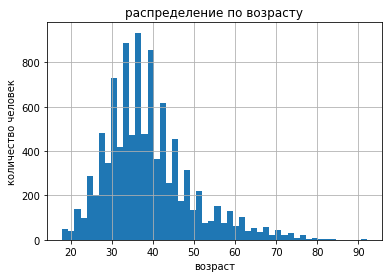

In [27]:
df['Age'].hist(bins=50)
plt.title('распределение по возрасту')
plt.xlabel('возраст')
plt.ylabel('количество человек')

In [28]:
df.loc[df['Age'] < 19]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
746,15787619,Hsieh,844,France,Male,18,2.0,160980.03,1,0,0,145936.28,0
1619,15770309,McDonald,656,France,Male,18,10.0,151762.74,1,0,1,127014.32,0
1678,15569178,Kharlamov,570,France,Female,18,NaN,82767.42,1,1,0,71811.90,0
2021,15795519,Vasiliev,716,Germany,Female,18,3.0,128743.80,1,0,0,197322.13,0
2136,15621893,Bellucci,727,France,Male,18,4.0,133550.67,1,1,1,46941.41,0
2141,15758372,Wallace,674,France,Male,18,7.0,0.00,2,1,1,55753.12,1
3330,15657439,Chao,738,France,Male,18,4.0,0.00,2,1,1,47799.15,0
3512,15657779,Boylan,806,Spain,Male,18,3.0,0.00,2,1,1,86994.54,0
3517,15757821,Burgess,771,Spain,Male,18,1.0,0.00,2,0,0,41542.95,0
3686,15665327,Cattaneo,706,France,Male,18,2.0,176139.50,2,1,0,129654.22,0


In [29]:
df.loc[df['Age'] > 75]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
252,15793726,Matveyeva,681,France,Female,79,0.0,0.00,2,0,1,170968.99,0
310,15712287,Pokrovskii,652,France,Female,80,4.0,0.00,2,1,1,188603.07,0
766,15810864,Williamson,700,France,Female,82,2.0,0.00,2,0,1,182055.36,0
1205,15724307,Mitchell,780,France,Male,76,10.0,121313.88,1,0,1,64872.33,0
1614,15646037,Sopuluchi,641,France,Male,77,9.0,0.00,3,1,1,81514.06,0
2164,15794479,Becker,767,Spain,Male,77,8.0,149083.70,1,1,1,190146.83,0
2458,15813303,Rearick,513,Spain,Male,88,10.0,0.00,2,1,1,52952.24,0
2925,15633531,Lavrov,717,France,Female,76,9.0,138489.66,1,1,1,68400.14,0
3033,15578006,Yao,787,France,Female,85,10.0,0.00,2,1,1,116537.96,0
3142,15586996,Azikiwe,697,France,Female,76,7.0,0.00,2,0,1,188772.45,0


Распределение по возрасту - нормальное. Посмотрел на данные лиц младше 19 - имеем данные только начиная с 18 лет, посмотрел на данные лиц старше 75 лет. Глазом не увидел привязки ухода из банка с возрастом.

Text(0, 0.5, 'количество человек')

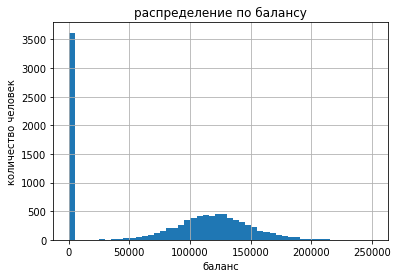

In [30]:
df['Balance'].hist(bins=50)
plt.title('распределение по балансу')
plt.xlabel('баланс')
plt.ylabel('количество человек')

Text(0, 0.5, 'количество человек')

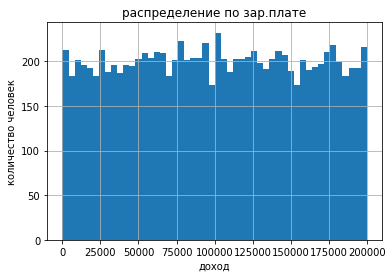

In [31]:
df['EstimatedSalary'].hist(bins=50)
plt.title('распределение по зар.плате')
plt.xlabel('доход')
plt.ylabel('количество человек')

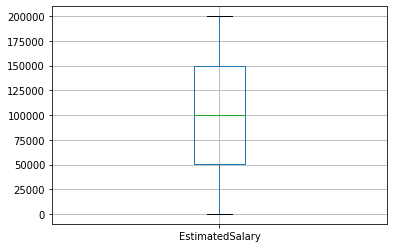

In [32]:
df.boxplot('EstimatedSalary')

In [33]:
df['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

__2. Подготовка данных__

Здесь мы приведем данные к нужному типу данных. Т.к. у нас два класса, которые должна предскказывать модель, то будем выбирать лучшую модель из типа классифицирующих, а значит нужно привести признаки типа 'object' к типу 'int', заменив на 0 и 1, для этого выберем метод One-Hot Encoding, т.к. мы будем выбирать лучшую модель, среди них будет и логистическая регрессия, для которой как раз подходит данный метод.

Признаки 'CustomerId' и 'Surname' считаю следует удалить.

In [34]:
without_tenure = without_tenure.drop(columns=['CustomerId', 'Surname'])
with_tenure = with_tenure.drop(columns=['CustomerId', 'Surname'])

In [35]:
without_tenure_ohe = pd.get_dummies(without_tenure, drop_first=True)
with_tenure_ohe = pd.get_dummies(with_tenure, drop_first=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


In [37]:
with_tenure_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
CreditScore          9091 non-null int64
Age                  9091 non-null int64
Tenure               9091 non-null float64
Balance              9091 non-null float64
NumOfProducts        9091 non-null int64
HasCrCard            9091 non-null int64
IsActiveMember       9091 non-null int64
EstimatedSalary      9091 non-null float64
Exited               9091 non-null int64
Geography_Germany    9091 non-null uint8
Geography_Spain      9091 non-null uint8
Gender_Male          9091 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 666.0 KB


In [38]:
without_tenure_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(6), uint8(3)
memory usage: 654.4 KB


Разделим датафрейм на обучающую, валидационную и тестовую выборки.

In [39]:
target_without = without_tenure_ohe['Exited']
features_without = without_tenure_ohe.drop('Exited', axis=1)

target_with= with_tenure_ohe['Exited']
features_with = with_tenure_ohe.drop('Exited', axis=1)

In [40]:
features_without_train, features_without_general, target_without_train, target_without_general = train_test_split(
    features_without, target_without, test_size=0.40, random_state=12345)

features_with_train, features_with_general, target_with_train, target_with_general = train_test_split(
    features_with, target_with, test_size=0.40, random_state=12345)

In [41]:
features_without_train.shape, features_without_general.shape, target_without_train.shape, target_without_general.shape

((6000, 10), (4000, 10), (6000,), (4000,))

In [42]:
features_with_train.shape, features_with_general.shape, target_with_train.shape, target_with_general.shape

((5454, 11), (3637, 11), (5454,), (3637,))

In [43]:
features_without_valid, features_without_test, target_without_valid, target_without_test = train_test_split(
    features_without_general, target_without_general, test_size=0.50, random_state=12345)

features_with_valid, features_with_test, target_with_valid, target_with_test = train_test_split(
    features_with_general, target_with_general, test_size=0.50, random_state=12345)

In [44]:
features_without_valid.shape, features_without_test.shape, target_without_valid.shape, target_without_test.shape

((2000, 10), (2000, 10), (2000,), (2000,))

In [45]:
features_with_valid.shape, features_with_test.shape, target_with_valid.shape, target_with_test.shape

((1818, 11), (1819, 11), (1818,), (1819,))

Также необходимо провести масштабирование признаков и стандартизовать их, чтобы модели считали все признаки равными. 


Определим признаки, которые будем масштабировать:

In [46]:
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

обучим наш scaler

In [47]:
scaler_without = StandardScaler()
scaler_without.fit(features_without_train[numeric])
scaler_with = StandardScaler()
scaler_with.fit(features_with_train[numeric])

features_without_train[numeric] = scaler_without.transform(features_without_train[numeric])
features_with_train[numeric] = scaler_with.transform(features_with_train[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

проведем масштабирование валидационной и тестовой выборок

In [48]:
features_without_valid[numeric] = scaler_without.transform(features_without_valid[numeric])
features_with_valid[numeric] = scaler_with.transform(features_with_valid[numeric])

features_without_test[numeric] = scaler_without.transform(features_without_test[numeric])
features_with_test[numeric] = scaler_with.transform(features_with_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

__Вывод__

Таким образом мы посмотрели на данные, изучили, посмотрели на распределения признаков. Попробовали найти выбросы. Выявили пропуски  данных, признак "Tenure" заполнен на 90%. Поэтому мы разбили наш датафрейм на 2 - с удаленными пропусками в данных и удаленным признаком, чтобы в тоом числе и посмотреть на качество моделей обученных на разных данных.

Далее мы провели прямое кодирование, избавились от дамми-ловушек и перевели признаки из типа object во float.

Разбили наши датафреймы на 3 выборки - тренировочная - 60% данных, валидационная и тестовая по 20% каждая.

Провели масштабирование, чтобы все признаки имели один вес и значимость для модели.

И готовы к следующему шагу.

# 2. Исследование задачи

В данном шаге мы попробуем подобрать параметры и обучить наши модели без учёта дисбаланса классов, а он есть - класс "0" составляет 80%.


__1. Датафрейм с признаком Tenure, но с 9091 объектами__


1. LogisticRegression

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
model_log_reg1 = LogisticRegression(random_state=12345)
model_log_reg1.fit(features_with_train, target_with_train)
prediction_valid = model_log_reg1.predict(features_with_valid)

probabilities_valid = model_log_reg1.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_with_valid, prediction_valid)

print('accuracy:', accuracy)
print('recall:', recall_score(target_with_valid, prediction_valid))
print('precision:', precision_score(target_with_valid, prediction_valid))
print('f1:', f1_score(target_with_valid, prediction_valid))
print('AUC-ROC', roc_auc_score(target_with_valid, prediction_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.8085808580858086
recall: 0.20159151193633953
precision: 0.6178861788617886
f1: 0.30400000000000005
AUC-ROC 0.5844876366066153


2. DecisionTreeRegressor

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [52]:
f1_max = 0
for depth in range(1, 21, 1):
    model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model_tree1.fit(features_with_train, target_with_train)
    predictions1 = model_tree1.predict(features_with_valid)
    
    f1 = f1_score(target_with_valid, predictions1)
        
    if f1_max < f1:
        f1_max = f1
        depth_max = depth

model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_with_train, target_with_train)
predictions1 = model_tree1.predict(features_with_valid)
    
print('max_depth:', depth_max)
print('recall:', recall_score(target_with_valid, predictions1))
print('precision:', precision_score(target_with_valid, predictions1))
print('f1:', f1_score(target_with_valid, predictions1))
print('AUC-ROC', roc_auc_score(target_with_valid, predictions1))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth: 7
recall: 0.48010610079575594
precision: 0.7211155378486056
f1: 0.5764331210191083
AUC-ROC 0.7157643619870521


Лучший результат достигнут при глубине дерева = 7:

    max_depth: 7
    recall: 0.48010610079575594
    precision: 0.7211155378486056
    f1: 0.5764331210191083
    AUC-ROC 0.7157643619870521

Далее посмотрим, как изменятся метрики качества, если изменим параметр max_leaf_nodes.

In [53]:
f1_max = 0
for nodes in range(2, 10, 1):
    for depth in range(1, 16, 1):
        model_tree1 = DecisionTreeClassifier(random_state = 22, max_depth=depth, max_leaf_nodes=nodes)
        model_tree1.fit(features_with_train, target_with_train)
        predictions1 = model_tree1.predict(features_with_valid)
    
        f1 = f1_score(target_with_valid, predictions1)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            nodes_max = nodes

model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_with_train, target_with_train)
predictions1 = model_tree1.predict(features_with_valid)

print('max_leaf_nodes:', nodes_max)
print('max_depth:', depth_max)
print('recall:', recall_score(target_with_valid, predictions1))
print('precision:', precision_score(target_with_valid, predictions1))
print('f1:', f1_score(target_with_valid, predictions1))
print('AUC-ROC', roc_auc_score(target_with_valid, predictions1))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

max_leaf_nodes: 9
max_depth: 4
recall: 0.4244031830238727
precision: 0.7476635514018691
f1: 0.5414551607445008
AUC-ROC 0.6934646033092994


Если поставить  max_leaf_nodes = 9 и глубину дерева = 4, то можно получить результат:
    
    max_leaf_nodes: 9
    max_depth: 4
    recall: 0.4244031830238727
    precision: 0.7476635514018691
    f1: 0.5414551607445008
    AUC-ROC 0.6934646033092994

Пока лучший результат = 0,57

3. RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
f1_max = 0
for estim in range(1, 100, 5):
    for depth in range(1, 21, 1):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_with_train, target_with_train)
        predictions = model_ran_for.predict(features_with_valid)
                    
        f1 = f1_score(target_with_valid, predictions)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            estim_max = estim
        
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_with_train, target_with_train)
predictions = model_ran_for.predict(features_with_valid)

print('деревьев в ансамбле:', estim_max)
print('max_depth:', depth_max)
print('recall:', recall_score(target_with_valid, predictions))
print('precision:', precision_score(target_with_valid, predictions))
print('f1:', f1_score(target_with_valid, predictions))
print('AUC-ROC:', roc_auc_score(target_with_valid, predictions))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

деревьев в ансамбле: 21
max_depth: 20
recall: 0.493368700265252
precision: 0.7591836734693878
f1: 0.5980707395498391
AUC-ROC: 0.72621245561493


Если посмотреть на весь список результатов и оценить его, то можно задаться вопросом:

Зачем уходить в дебри и тратить время и ресурс, когда лес с 21 деревьями даёт результат тайги из 81 дерева:

    деревьев в ансамбле: 21
    max_depth: 20
    recall: 0.493368700265252
    precision: 0.7591836734693878
    f1: 0.5980707395498391
    AUC-ROC: 0.72621245561493
    
    деревьев в ансамбле: 81
    max_depth: 17
    recall: 0.47745358090185674
    precision: 0.7929515418502202
    f1: 0.5960264900662251
    AUC-ROC: 0.7224186710893739
    
Таким образом приходит мысль, что форму ``if f1_max < f1:`` можно "оптимизировать", добавив "(f1_max-0.0N) < f1", где N - допустимый в меньшую сторону результат, чтобы съэкономить на глубине и ансамбле. Но мы не будем тут к этому прибегать, т.к. у нас главная цель ф1 строго больше 0,59 и нет ни слова о времени работы такого дерева.

__2. Датафрейм без признака Tenure, но с 10000 объектов__

1. LogisticRegression

In [56]:
model_log_reg2 = LogisticRegression(random_state=12345)
model_log_reg2.fit(features_without_train, target_without_train)
prediction_valid = model_log_reg2.predict(features_without_valid)

probabilities_valid = model_log_reg2.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy = accuracy_score(target_without_valid, prediction_valid)

print('accuracy:', accuracy)
print('recall:', recall_score(target_without_valid, prediction_valid))
print('precision:', precision_score(target_without_valid, prediction_valid))
print('f1:', f1_score(target_without_valid, prediction_valid))
print('AUC-ROC', roc_auc_score(target_without_valid, prediction_valid))

accuracy: 0.803
recall: 0.22727272727272727
precision: 0.572289156626506
f1: 0.3253424657534246
AUC-ROC 0.5911964142052638


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Щекотливый вывод!

Оказывается, что касается логистической регрессии, то лучше пожертвовать признаком, если он не критичен (в данном случае он не критичен точно) и увеличить размер обучающей выборки  на 10%, правда, чтобы сказать абсолютно точно - нужно подтвердить это с данными, где будет признак Tenure и будет 10000 объектов, иначе признак Tenure лишь путает модель.

результат прошлой модели (с признаком Tenure, но 9091 объектами):

    accuracy: 0.8085808580858086
    recall: 0.20159151193633953
    precision: 0.6178861788617886
    f1: 0.30400000000000005
    AUC-ROC 0.5844876366066153
    
результат модели без признака Tenure, но с 10000 объектами:

    accuracy: 0.803
    recall: 0.22727272727272727
    precision: 0.572289156626506
    f1: 0.3253424657534246
    AUC-ROC 0.5911964142052638

2. DecisionTreeRegressor

In [57]:
f1_max = 0
for depth in range(1, 21, 1):
    model_tree2 = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model_tree2.fit(features_without_train, target_without_train)
    predictions2 = model_tree2.predict(features_without_valid)
    
    f1 = f1_score(target_without_valid, predictions2)
        
    if f1_max < f1:
        f1_max = f1
        depth_max = depth
            
model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_without_train, target_without_train)
predictions2 = model_tree1.predict(features_without_valid)

print('max_depth:', depth_max)
print('recall:', recall_score(target_without_valid, predictions2))
print('precision:', precision_score(target_without_valid, predictions2))
print('f1:', f1_score(target_without_valid, predictions2))
print('AUC-ROC', roc_auc_score(target_without_valid, predictions2))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth: 6
recall: 0.4473684210526316
precision: 0.7695473251028807
f1: 0.5658093797276854
AUC-ROC 0.7059850954820679


С решающим деревом картина выглядит иначе, чем с логистической регрессией.

Решающее дерево без признака Tenure даёт свой лучший результат при глубине = 6, но на сотую долю хуже.

результат модели без признака Tenure, но с 10000 объектами:

    max_depth: 6
    recall: 0.4473684210526316
    precision: 0.7695473251028807
    f1: 0.5658093797276854
    AUC-ROC 0.7059850954820679

результат прошлой модели (с признаком Tenure, но 9091 объектами):

    max_depth: 7
    recall: 0.48010610079575594
    precision: 0.7211155378486056
    f1: 0.5764331210191083
    AUC-ROC 0.7157643619870521
    
    
 Далее проверим её работу с параметром max_leaf_nodes

In [58]:
f1_max = 0
for nodes in range(2, 10, 1):
    for depth in range(1, 16, 1):
        model_tree2 = DecisionTreeClassifier(random_state = 22, max_depth=depth, max_leaf_nodes=nodes)
        model_tree2.fit(features_without_train, target_without_train)
        predictions2 = model_tree2.predict(features_without_valid)
    
        f1 = f1_score(target_without_valid, predictions2)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            nodes_max = nodes

model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_without_train, target_without_train)
predictions1 = model_tree1.predict(features_without_valid)

print('max_leaf_nodes:', nodes_max)
print('max_depth:', depth_max)
print('recall:', recall_score(target_without_valid, predictions1))
print('precision:', precision_score(target_without_valid, predictions1))
print('f1:', f1_score(target_without_valid, predictions1))
print('AUC-ROC', roc_auc_score(target_without_valid, predictions1))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

max_leaf_nodes: 9
max_depth: 4
recall: 0.43779904306220097
precision: 0.75
f1: 0.5528700906344411
AUC-ROC 0.699620128357902


Параметр max_leaf_nodes позволяет сократить глубину дерева, но не превышает качество модели с большей глубиной и без этого параметра, давая качество хуже, в данном случае:

с параметром max_leaf_nodes и глубиной 4:

    max_leaf_nodes: 9
    max_depth: 4
    recall: 0.43779904306220097
    precision: 0.75
    f1: 0.5528700906344411
    AUC-ROC 0.699620128357902

без парамемтра max_leaf_nodes, и глубиной 6:

    max_depth: 6
    recall: 0.4473684210526316
    precision: 0.7695473251028807
    f1: 0.5658093797276854
    AUC-ROC 0.7059850954820679

3. RandomForestClassifier

In [59]:
f1_max = 0
for estim in range(1, 100, 5):
    for depth in range(1, 21, 1):
        model_ran_for2 = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for2.fit(features_without_train, target_without_train)
        predictions = model_ran_for2.predict(features_without_valid)
        
        f1 = f1_score(target_without_valid, predictions)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            estim_max = estim
        
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_without_train, target_without_train)
predictions = model_ran_for.predict(features_without_valid)

print('деревьев в ансамбле:', estim_max)
print('max_depth:', depth_max)
print('recall:', recall_score(target_without_valid, predictions))
print('precision:', precision_score(target_without_valid, predictions))
print('f1:', f1_score(target_without_valid, predictions))
print('AUC-ROC:', roc_auc_score(target_without_valid, predictions))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

деревьев в ансамбле: 31
max_depth: 19
recall: 0.48564593301435405
precision: 0.7718631178707225
f1: 0.5961820851688693
AUC-ROC: 0.7238596289597687


Должен указать, что хороший результат дало одно дерево в ансамбле с глубиной 7, ощутимо лучше, чем с признаком Tenure:

    деревьев в ансамбле: 1
    max_depth: 7
    recall: 0.5406698564593302
    precision: 0.6627565982404692
    f1: 0.5955204216073781
    AUC-ROC: 0.733988531263799

Наверно на нем и стоит остановиться, ибо с ростом деревьев в ансамбле результат не становится лучше.

Лучший результат модели с признаком Tenure:

    деревьев в ансамбле: 31
    max_depth: 19
    recall: 0.48564593301435405
    precision: 0.7718631178707225
    f1: 0.5961820851688693
    AUC-ROC: 0.7238596289597687
    
Стоит заметить, что для случайного леса признак Tenure не имеет значимости, т.к. результат сопоставим с результатом модели учившейся на выборке с признаком Tenure, но выборка была меньше на 10%, есть предположение, что без него может быть даже лучше, т.к. одинокое дерево в ансамбле дало прекрасный результат, лучше, чем одинокое дерево ансамбля с обучающей выборкой содержащей признак Tenure, но на 10% меньше.

__Вывод общий__

Таким образом с задачей справляется лучше - модель случайного леса. Причем стоит заметить, что одно дерево в ансамбле работает сопоставимо со множеством деревьев в ансамбле. Лучший резульат = 0.596 - показала модель с признаком Tenure, но выборка обучающая была на 10% меньше.

Добавлю, что с параметром max_leaf_nodes решающее дерево даёт результат хуже, чем без этого параметра, поэтому в последующем не будем им пользоваться.

# 3. Борьба с дисбалансом

В этом шаге попробуем разные методы борьбы с дисбалансом и выберем самый эффективный для нашей задачи.

Попробуем такие методы:

1. Увеличение выборки - Upsampling.
2. Уменьшение выборки - Downsampling.
3. Эксперимент с весом класса.


__1. Upsampling__

Чтобы увеличить выборку и все автоматизировать, нам понадобится функция. Напишем ее ниже.

In [60]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [61]:
features_upsampled_with, target_upsampled_with = upsample(features_with_train, target_with_train, 10)

In [62]:
features_upsampled_without, target_upsampled_without = upsample(features_without_train, target_without_train, 10)

1. Ответ линейной регрессии обученной на выборках с признаком Tenure и без с применением метода Upsampling для балансировки обучающих выборок.

In [63]:
model_log_reg_with = LogisticRegression(random_state=12345)
model_log_reg_with.fit(features_upsampled_with, target_upsampled_with)

predicted_valid = model_log_reg_with.predict(features_with_valid)

print('recall:', recall_score(target_with_valid, predicted_valid))
print('precision:', precision_score(target_with_valid, predicted_valid))
print('f1:', f1_score(target_with_valid, predicted_valid))
print('AUC-ROC', roc_auc_score(target_with_valid, predicted_valid))

recall: 0.9310344827586207
precision: 0.26732673267326734
f1: 0.41538461538461535
AUC-ROC 0.6317212663619611


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [64]:
model_log_reg_without = LogisticRegression(random_state=12345)
model_log_reg_without.fit(features_upsampled_without, target_upsampled_without)

predicted_valid = model_log_reg_without.predict(features_without_valid)

print('recall:', recall_score(target_without_valid, predicted_valid))
print('precision:', precision_score(target_without_valid, predicted_valid))
print('f1:', f1_score(target_without_valid, predicted_valid))
print('AUC-ROC', roc_auc_score(target_without_valid, predicted_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


recall: 0.9114832535885168
precision: 0.2741007194244604
f1: 0.42146017699115046
AUC-ROC 0.636841500372008


Метод Upsampling повысил метрику f1 на 1 десятую, подняв показатель с 0,3 до 0,4, также линейная регрессия, обученная на выборке без признака Tenure, имеет лучший результат на 1 сотую.

2. Ответ решающего дерева обученного на выборках с применением метода Upsampling для балансировки с признаком Tenure и без.

In [65]:
f1_max =0
for depth in range(1, 21, 1):
    model_tree_with = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model_tree_with.fit(features_upsampled_with, target_upsampled_with)
    predictions1 = model_tree_with.predict(features_with_valid)

    
    f1 = f1_score(target_with_valid, predictions1)
        
    if f1_max < f1:
        f1_max = f1
        depth_max = depth
            
model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_upsampled_with, target_upsampled_with)
predictions2 = model_tree1.predict(features_with_valid)

print('max_depth:', depth_max)
print('recall:', recall_score(target_with_valid, predictions2))
print('precision:', precision_score(target_with_valid, predictions2))
print('f1:', f1_score(target_with_valid, predictions2))
print('AUC-ROC', roc_auc_score(target_with_valid, predictions2))

max_depth: 6
recall: 0.8461538461538461
precision: 0.3923739237392374
f1: 0.5361344537815127
AUC-ROC 0.7516681791490952


In [66]:
f1_max = 0
for depth in range(1, 21, 1):
    model_tree_without = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model_tree_without.fit(features_upsampled_without, target_upsampled_without)
    predictions1 = model_tree_without.predict(features_without_valid)

    f1 = f1_score(target_without_valid, predictions1)
        
    if f1_max < f1:
        f1_max = f1
        depth_max = depth
            
model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_upsampled_without, target_upsampled_without)
predictions2 = model_tree1.predict(features_without_valid)

print('max_depth:', depth_max)
print('recall:', recall_score(target_without_valid, predictions2))
print('precision:', precision_score(target_without_valid, predictions2))
print('f1:', f1_score(target_without_valid, predictions2))
print('AUC-ROC', roc_auc_score(target_without_valid, predictions2))

max_depth: 7
recall: 0.8014354066985646
precision: 0.38550057537399307
f1: 0.5205905205905206
AUC-ROC 0.7319439991773481


Дерево не дало ожидаемого результата, наоборот, показало результаты обучения на сбалансированной выборке хуже, чем на несбалансированной.

Лучший результат на несбалансированной и сбалансированной, но с признаком Tenure:

    max_depth: 7                          .max_depth: 6
    recall: 0.48010610079575594           .recall: 0.8461538461538461
    precision: 0.7211155378486056         .precision: 0.3923739237392374
    f1: 0.5764331210191083                .f1: 0.5361344537815127
    AUC-ROC 0.7157643619870521            .AUC-ROC 0.7516681791490952

Лучший результат на несбалансированной и сбалансированной, но без признака Tenure:

    max_depth: 6                          .max_depth: 7
    recall: 0.4473684210526316            .recall: 0.8014354066985646
    precision: 0.7695473251028807         .precision: 0.38550057537399307
    f1: 0.5658093797276854                .f1: 0.5205905205905206
    AUC-ROC 0.7059850954820679            .AUC-ROC 0.7319439991773481



3. Ответ случайного леса обученного на выборках с признаком Tenure и без с применением метода Upsampling для балансировки обучающих выборок.

In [67]:
f1_max = 0
for estim in range(51, 106, 5):
    for depth in range(1, 21, 1):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_upsampled_with, target_upsampled_with)
        predictions = model_ran_for.predict(features_with_valid)
        
        f1 = f1_score(target_with_valid, predictions)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            estim_max = estim
        
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_upsampled_with, target_upsampled_with)
predictions = model_ran_for.predict(features_with_valid)

print('деревьев в ансамбле:', estim_max)
print('max_depth:', depth_max)
print('recall:', recall_score(target_with_valid, predictions))
print('precision:', precision_score(target_with_valid, predictions))
print('f1:', f1_score(target_with_valid, predictions))
print('AUC-ROC:', roc_auc_score(target_with_valid, predictions))

деревьев в ансамбле: 96
max_depth: 17
recall: 0.6021220159151194
precision: 0.6656891495601173
f1: 0.6323119777158774
AUC-ROC: 0.7615051439742149


In [68]:
f1_max = 0
for estim in range(1, 52, 5):
    for depth in range(1, 21, 1):
        model_ran_for2 = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for2.fit(features_upsampled_without, target_upsampled_without)
        predictions = model_ran_for2.predict(features_without_valid)
        
        f1 = f1_score(target_without_valid, predictions)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            estim_max = estim
        
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_upsampled_without, target_upsampled_without)
predictions = model_ran_for.predict(features_without_valid)

print('деревьев в ансамбле:', estim_max)
print('max_depth:', depth_max)
print('recall:', recall_score(target_without_valid, predictions))
print('precision:', precision_score(target_without_valid, predictions))
print('f1:', f1_score(target_without_valid, predictions))
print('AUC-ROC:', roc_auc_score(target_without_valid, predictions))

деревьев в ансамбле: 51
max_depth: 20
recall: 0.5645933014354066
precision: 0.6647887323943662
f1: 0.6106080206985769
AUC-ROC: 0.7446860312486768


Случайный лес показал результат противоположный решающему дереву. Метод Upsempling для балансировки обучающей выборки улучшил его метрики. Причем для данной модели признак Tenure оказался весьма нужным! Давайте посмотрим на лучшие реультаты:

Перед нами результаты модели случайного леса обученной без балансировки и с балансировкой с признаком Tenure:

    деревьев в ансамбле: 26.               .деревьев в ансамбле: 71
    max_depth: 16                          .max_depth: 17
    recall: 0.4907161803713528             .recall: 0.5994694960212201
    precision: 0.7520325203252033          .precision: 0.6726190476190477
    f1: 0.593900481540931                  .f1: 0.6339410939691444
    AUC-ROC 0.7241922331419568             .AUC-ROC: 0.7615668090793123

Перед нами результаты модели случайного леса обученной без балансировки и с балансировкой без признака Tenure:

    деревьев в ансамбле: 1                 .деревьев в ансамбле: 36
    max_depth: 7                           .max_depth: 19
    recall: 0.5406698564593302             .recall: 0.5645933014354066
    precision: 0.6627565982404692          .precision: 0.6666666666666666
    f1: 0.5955204216073781                 .f1: 0.6113989637305699
    AUC-ROC: 0.733988531263799             .AUC-ROC: 0.7450020868744669
    
Признак Tenure дает нам 2 сотые в точности метрики ф1! Однозначно его стоит оставить в выборке!

__2. Downsampling__

Чтобы верно уменьшить выборку и все автоматизировать, нам понадобится функция. Напишем ее ниже.

In [69]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [70]:
features_downsampled_with, target_downsampled_with = downsample(features_with_train, target_with_train, 0.1)

In [71]:
features_downsampled_without, target_downsampled_without = downsample(features_without_train, target_without_train, 0.1)

1. Ответ линейной регрессии обученной на выборках с признаком Tenure и без с применением метода Downsampling для балансировки обучающих выборок.

In [72]:
model = LogisticRegression(random_state=12345)
model.fit(features_downsampled_with, target_downsampled_with)

predicted_valid = model.predict(features_with_valid)

print("F1:", f1_score(target_with_valid, predicted_valid))

F1: 0.4135071090047393


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [73]:
model = LogisticRegression(random_state=12345)
model.fit(features_downsampled_without, target_downsampled_without)

predicted_valid = model.predict(features_without_valid)

print("F1:", f1_score(target_without_valid, predicted_valid))

F1: 0.42841037204058624


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Результат лучше,чем при обучении на несбалансированной выборке, сопоставим с результатом при обучении на выборке сбалансированной методом Upsampking, но продолжает оставлять желать лучшего ((

2. Ответ решающего дерева обученного на выборках с применением метода Downsampling для балансировки с признаком Tenure и без.

In [74]:
f1_max = 0
for depth in range(1, 21, 1):
    model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model_tree1.fit(features_downsampled_with, target_downsampled_with)
    predictions1 = model_tree1.predict(features_with_valid)
    
    f1 = f1_score(target_with_valid, predictions1)
        
    if f1_max < f1:
        f1_max = f1
        depth_max = depth
            
model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_downsampled_with, target_downsampled_with)
predictions2 = model_tree1.predict(features_with_valid)

print('max_depth:', depth_max)
print('recall:', recall_score(target_with_valid, predictions2))
print('precision:', precision_score(target_with_valid, predictions2))
print('f1:', f1_score(target_with_valid, predictions2))
print('AUC-ROC', roc_auc_score(target_with_valid, predictions2))

max_depth: 5
recall: 0.8885941644562334
precision: 0.3625541125541126
f1: 0.5149884704073789
AUC-ROC 0.7399251183141682


In [75]:
f1_max = 0
for depth in range(1, 21, 1):
    model_tree2 = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model_tree2.fit(features_downsampled_without, target_downsampled_without)
    predictions2 = model_tree2.predict(features_without_valid)
    
    f1 = f1_score(target_without_valid, predictions2)
        
    if f1_max < f1:
        f1_max = f1
        depth_max = depth
            
model_tree1 = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model_tree1.fit(features_downsampled_without, target_downsampled_without)
predictions2 = model_tree1.predict(features_without_valid)

print('max_depth:', depth_max)
print('recall:', recall_score(target_without_valid, predictions2))
print('precision:', precision_score(target_without_valid, predictions2))
print('f1:', f1_score(target_without_valid, predictions2))
print('AUC-ROC', roc_auc_score(target_without_valid, predictions2))

max_depth: 5
recall: 0.8636363636363636
precision: 0.3474494706448508
f1: 0.49553877831159915
AUC-ROC 0.7175324675324675


Полученный ответ от моделей, обученныз на сбалансированных выборках методом Downsampling, не стоит того, чтобы о нем много говорить, лишь подтвердил общие выводы, полученные при работе на выборках сбалансированных методом Upsampling, а именно:

Дерево учится лучше на оригинальной несбалансированной выборке.

Признак Tenure ощутимо важен.

Результат хуже, чем при методе Upsampling на пару сотых, которые весьма критичны для нас.

3. Ответ случайного леса обученного на выборках с признаком Tenure и без с применением метода Downsampling для балансировки обучающих выборок.

In [76]:
f1_max = 0

for estim in range(1, 106, 5):
    for depth in range(1, 21, 1):
        model_ran_for_down = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for_down.fit(features_downsampled_with, target_downsampled_with)
        predictions = model_ran_for_down.predict(features_with_valid)
        
        f1 = f1_score(target_with_valid, predictions)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            estim_max = estim

model_ran_for_down = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for_down.fit(features_downsampled_with, target_downsampled_with)
predictions = model_ran_for_down.predict(features_with_valid)
print('деревьев в ансамбле:', estim_max)
print('max_depth:', depth_max)
print('recall:', recall_score(target_with_valid, predictions))
print('precision:', precision_score(target_with_valid, predictions))
print('f1:', f1_score(target_with_valid, predictions))
print('AUC-ROC:', roc_auc_score(target_with_valid, predictions))

деревьев в ансамбле: 16
max_depth: 19
recall: 0.9071618037135278
precision: 0.3326848249027237
f1: 0.48683274021352313
AUC-ROC: 0.715551755430671


In [77]:
for estim in range(1, 52, 5):
    for depth in range(1, 21, 1):
        model_ran_for_down2 = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for_down2.fit(features_downsampled_without, target_downsampled_without)
        predictions = model_ran_for_down2.predict(features_without_valid)
        
        f1 = f1_score(target_without_valid, predictions)
        
        if f1_max < f1:
            f1_max = f1
            depth_max = depth
            estim_max = estim
        
model_ran_for_down2 = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for_down2.fit(features_downsampled_without, target_downsampled_without)
predictions = model_ran_for_down2.predict(features_without_valid)
print('деревьев в ансамбле:', estim)
print('max_depth:', depth)
print('recall:', recall_score(target_without_valid, predictions))
print('precision:', precision_score(target_without_valid, predictions))
print('f1:', f1_score(target_without_valid, predictions))
print('AUC-ROC:', roc_auc_score(target_without_valid, predictions))

деревьев в ансамбле: 51
max_depth: 20
recall: 0.7894736842105263
precision: 0.35752979414951247
f1: 0.4921700223713646
AUC-ROC: 0.7073158560117107


Хм...

Метод Downsampling оказался весьма неподходящим! Результат хуже, чем у решающего дерева!

Считаю нужнам этим и закончить эту часть и перейти к следующему неоднозначному методу - эксперимент с изменением порога вероятноссти!


__3. Меняем порог__

Предлогаю разбить этот шаг на 2 подшага. Посмотреть на модели, обучившихся на несбалансированных выборках, но с изменением порога. И посмотреть как поведёт себя модель, обучающаяся на сбалансированной выборке и с изменённым порогом, ради интереса....

1. Ответ линейной регрессии с изменением порога.

            модель обучена на несбалансированной выборке с признаком Tenure:

In [78]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_with_train, target_with_train)
probabilities_valid = model.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
threshold_max = 0
for threshold in np.arange(0, 0.4, 0.02):  
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_with_valid, predicted_valid)
    if f1_max < f1:
        f1_max = f1
        threshold_max = threshold
    
predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
    
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(threshold_max, precision, recall, f1, auc_roc))

Порог = 0.22 | Точность = 0.400, Полнота = 0.692, f1 = 0.507, AUC-ROC = 0.710


            модель обучена на несбалансированной выборке без признака Tenure:
            

In [79]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_without_train, target_without_train)
probabilities_valid = model.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
threshold_max = 0
for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_without_valid, predicted_valid)
    if f1_max < f1:
        f1_max = f1
        threshold_max = threshold
    
predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
    
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(threshold_max, precision, recall, f1, auc_roc))

Порог = 0.26 | Точность = 0.435, Полнота = 0.591, f1 = 0.501, AUC-ROC = 0.694


            модель обучена на сбалансированной выборке методом Upsampling с признаком Tenure:
            

In [80]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled_with, target_upsampled_with)
probabilities_valid = model.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
threshold_max = 0
for threshold in np.arange(0.2, 0.9, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_with_valid, predicted_valid)
    if f1_max < f1:
        f1_max = f1
        threshold_max = threshold
    
predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
    
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(threshold_max, precision, recall, f1, auc_roc))

Порог = 0.78 | Точность = 0.460, Полнота = 0.594, f1 = 0.519, AUC-ROC = 0.706


            модель обучена на сбалансированной выборке методом Upsampling без признака Tenure:
            

In [81]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled_without, target_upsampled_without)
probabilities_valid = model.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
threshold_max = 0
for threshold in np.arange(0.5, 0.9, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_without_valid, predicted_valid)
    if f1_max < f1:
        f1_max = f1
        threshold_max = threshold
    
predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
    
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(threshold_max, precision, recall, f1, auc_roc))

Порог = 0.74 | Точность = 0.409, Полнота = 0.651, f1 = 0.502, AUC-ROC = 0.701


            модель обучена на сбалансированной выборке методом Downsampling c признаком Tenure:
            

In [82]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled_with, target_downsampled_with)
probabilities_valid = model.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
threshold_max = 0
for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_with_valid, predicted_valid)
    if f1_max < f1:
        f1_max = f1
        threshold_max = threshold
    
predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(threshold_max, precision, recall, f1, auc_roc))

Порог = 0.72 | Точность = 0.388, Полнота = 0.737, f1 = 0.508, AUC-ROC = 0.716


            модель обучена на сбалансированной выборке методом Downsampling без признака Tenure:
            

In [83]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled_without, target_downsampled_without)
probabilities_valid = model.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]

f1_max = 0
threshold_max = 0
for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_without_valid, predicted_valid)
    if f1_max < f1:
        f1_max = f1
        threshold_max = threshold
    
predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(threshold_max, precision, recall, f1, auc_roc))

Порог = 0.74 | Точность = 0.405, Полнота = 0.648, f1 = 0.499, AUC-ROC = 0.698


Мы посмотрели на метрики моделей, обученных на несбалансированных выборках и сбалансированных методами Upsampling и Downsampling. Во всех случаях - лучший результат у моделей, обучающихся на выборке с признаком Tenure, значит есть незаметная зависимость.

Самый __лучший__ результат __f1__ из выдаваемых __логистической регрессией__ - __0,519__, был получен при обучении модели на сбалансированной методом Upsampling выборке с изменением порога:

    Порог = 0.78 | Точность = 0.460, Полнота = 0.594, f1 = 0.519, AUC-ROC = 0.706
    
 

                                                    ***

2. Ответы решающего дерева при изменении порога.

            модель обучена на несбалансированной выборке с признаком Tenure:        

In [84]:
f1_max = 0
threshold_max = 0
depth_max = 0
for depth in range(1, 21, 1):
    model = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model.fit(features_with_train, target_with_train)
    
    probabilities_valid = model.predict_proba(features_with_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold in np.arange(0, 0.9, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_with_valid, predicted_valid)
        if f1_max < f1:
            f1_max = f1
            threshold_max = threshold
            depth_max = depth

model = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model.fit(features_with_train, target_with_train)
probabilities_valid = model.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > threshold_max

precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
print("Глубина = {:.0f}, Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(depth_max, threshold_max, precision, recall, f1, auc_roc))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Глубина = 7, Порог = 0.28 | Точность = 0.622, Полнота = 0.623, f1 = 0.623, AUC-ROC = 0.762


            модель обучена на несбалансированной выборке без признака Tenure:
            

In [85]:
f1_max = 0
threshold_max = 0
depth_max = 0
for depth in range(1, 21, 1):
    model = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model.fit(features_without_train, target_without_train)
    
    probabilities_valid = model.predict_proba(features_without_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold in np.arange(0, 0.9, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_without_valid, predicted_valid)
        if f1_max < f1:
            f1_max = f1
            threshold_max = threshold
            depth_max = depth

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
model = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model.fit(features_without_train, target_without_train)
probabilities_valid = model.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > threshold_max

precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
print("Глубина = {:.0f}, Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(depth_max, threshold_max, precision, recall, f1, auc_roc))

Глубина = 6, Порог = 0.26 | Точность = 0.622, Полнота = 0.584, f1 = 0.602, AUC-ROC = 0.745


        модель обучена на сбалансированной выборке методом Upsampling с признаком Tenure:
        

In [87]:
f1_max = 0
threshold_max = 0
depth_max = 0
for depth in range(1, 21, 1):
    model = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model.fit(features_upsampled_with, target_upsampled_with)
    
    probabilities_valid = model.predict_proba(features_with_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold in np.arange(0, 0.9, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_with_valid, predicted_valid)
        if f1_max < f1:
            f1_max = f1
            threshold_max = threshold
            depth_max = depth

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [88]:
model = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model.fit(features_upsampled_with, target_upsampled_with)
probabilities_valid = model.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > threshold_max

precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
print("Глубина = {:.0f}, Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(depth_max, threshold_max, precision, recall, f1, auc_roc))

Глубина = 6, Порог = 0.84 | Точность = 0.598, Полнота = 0.623, f1 = 0.610, AUC-ROC = 0.757


            модель обучена на сбалансированной выборке методом Upsampling без признака Tenure:
            

In [89]:
f1_max = 0
threshold_max = 0
depth_max = 0
for depth in range(1, 21, 1):
    model = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model.fit(features_upsampled_without, target_upsampled_without)
    
    probabilities_valid = model.predict_proba(features_without_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold in np.arange(0, 0.9, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_without_valid, predicted_valid)
        if f1_max < f1:
            f1_max = f1
            threshold_max = threshold
            depth_max = depth

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
model = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model.fit(features_upsampled_without, target_upsampled_without)
probabilities_valid = model.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > threshold_max

precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
print("Глубина = {:.0f}, Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(depth_max, threshold_max, precision, recall, f1, auc_roc))

Глубина = 7, Порог = 0.84 | Точность = 0.602, Полнота = 0.598, f1 = 0.600, AUC-ROC = 0.747


            модель обучена на сбалансированной выборке методом Downsampling c признаком Tenure:
            

In [91]:
f1_max = 0
threshold_max = 0
depth_max = 0
for depth in range(1, 21, 1):
    model = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model.fit(features_downsampled_with, target_downsampled_with)
    
    probabilities_valid = model.predict_proba(features_with_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold in np.arange(0, 0.9, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_with_valid, predicted_valid)
        if f1_max < f1:
            f1_max = f1
            threshold_max = threshold
            depth_max = depth

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
model = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model.fit(features_downsampled_with, target_downsampled_with)
probabilities_valid = model.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > threshold_max

precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
print("Глубина = {:.0f}, Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(depth_max, threshold_max, precision, recall, f1, auc_roc))

Глубина = 5, Порог = 0.86 | Точность = 0.555, Полнота = 0.605, f1 = 0.579, AUC-ROC = 0.739


            модель обучена на сбалансированной выборке методом Downsampling без признака Tenure:
            

In [93]:
f1_max = 0
threshold_max = 0
depth_max = 0
for depth in range(1, 21, 1):
    model = DecisionTreeClassifier(random_state = 12345, max_depth=depth)
    model.fit(features_downsampled_without, target_downsampled_without)
    
    probabilities_valid = model.predict_proba(features_without_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold in np.arange(0, 0.9, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_without_valid, predicted_valid)
        if f1_max < f1:
            f1_max = f1
            threshold_max = threshold
            depth_max = depth

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
model = DecisionTreeClassifier(random_state = 12345, max_depth=depth_max)
model.fit(features_downsampled_without, target_downsampled_without)
probabilities_valid = model.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > threshold_max

precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
print("Глубина = {:.0f}, Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(depth_max, threshold_max, precision, recall, f1, auc_roc))

Глубина = 6, Порог = 0.76 | Точность = 0.515, Полнота = 0.653, f1 = 0.576, AUC-ROC = 0.745


__Вывод__


Очевидно, что вмешиваться в порог - стоит! Метрика f1 разом выросла! причем наибольший результат был получен при изменении порога при обучении на несбалансированной выборке с признаком Tenure:

``Глубина = 7, Порог = 0.28 | Точность = 0.622, Полнота = 0.623, f1 = 0.623, AUC-ROC = 0.762``

                                                   ***

3. Ответы случайного леса при изменении порога.


            модель обучена на несбалансированной выборке с признаком Tenure:  

In [95]:
f1_max = 0
for estim in range(1, 101, 5):
    for depth in range(1, 21, 2):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_with_train, target_with_train)
        
        probabilities_valid = model_ran_for.predict_proba(features_with_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        for threshold in np.arange(0.1, 0.9, 0.01):
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_with_valid, predicted_valid)
            if f1_max < f1:
                f1_max = f1
                estim_max = estim
                depth_max = depth
                threshold_max = threshold

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

In [96]:
model_ran_for_test = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for_test.fit(features_with_train, target_with_train)
        
probabilities_valid = model_ran_for_test.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
print("Деревьев в ансамбле = {:.0f}, Глубина = {:.0f}, Порог = {:.2f}".format(estim_max, depth_max, threshold_max))
print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(precision, recall, f1, auc_roc))


Деревьев в ансамбле = 86, Глубина = 7, Порог = 0.31
Точность = 0.692, Полнота = 0.637, f1 = 0.663, AUC-ROC = 0.781



                    модель обучена на несбалансированной выборке без признака Tenure:

In [97]:
f1_max = 0
for estim in range(1, 101, 5):
    for depth in range(1, 21, 2):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_without_train, target_without_train)
        
        probabilities_valid = model_ran_for.predict_proba(features_without_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        for threshold in np.arange(0.1, 0.9, 0.01):
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_without_valid, predicted_valid)
            if f1_max < f1:
                f1_max = f1
                estim_max = estim
                depth_max = depth
                threshold_max = threshold

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

In [98]:
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_without_train, target_without_train)
        
probabilities_valid = model_ran_for.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
print("Деревьев в ансамбле = {:.0f}, Глубина = {:.0f}, Порог = {:.2f}".format(estim_max, depth_max, threshold_max))
print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(precision, recall, f1, auc_roc))


Деревьев в ансамбле = 81, Глубина = 7, Порог = 0.27
Точность = 0.631, Полнота = 0.658, f1 = 0.644, AUC-ROC = 0.778



                    модель обучена на сбалансированной выборке методом Upsampling с признаком Tenure:

In [99]:
f1_max = 0
for estim in range(1, 101, 5):
    for depth in range(1, 21, 2):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_upsampled_with, target_upsampled_with)
        
        probabilities_valid = model_ran_for.predict_proba(features_with_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        for threshold in np.arange(0.1, 0.9, 0.01):
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_with_valid, predicted_valid)
            if f1_max < f1:
                f1_max = f1
                estim_max = estim
                depth_max = depth
                threshold_max = threshold

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

In [100]:
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_upsampled_with, target_upsampled_with)
        
probabilities_valid = model_ran_for.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
print("Деревьев в ансамбле = {:.0f}, Глубина = {:.0f}, Порог = {:.2f}".format(estim_max, depth_max, threshold_max))
print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(precision, recall, f1, auc_roc))


Деревьев в ансамбле = 66, Глубина = 7, Порог = 0.77
Точность = 0.646, Полнота = 0.647, f1 = 0.646, AUC-ROC = 0.777



                     модель обучена на сбалансированной выборке методом Upsampling без признака Tenure:

In [101]:
f1_max = 0
for estim in range(1, 101, 5):
    for depth in range(1, 21, 2):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_upsampled_without, target_upsampled_without)
        
        probabilities_valid = model_ran_for.predict_proba(features_without_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        for threshold in np.arange(0.1, 0.9, 0.01):
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_without_valid, predicted_valid)
            if f1_max < f1:
                f1_max = f1
                estim_max = estim
                depth_max = depth
                threshold_max = threshold

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

In [102]:
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_upsampled_without, target_upsampled_without)
        
probabilities_valid = model_ran_for.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
print("Деревьев в ансамбле = {:.0f}, Глубина = {:.0f}, Порог = {:.2f}".format(estim_max, depth_max, threshold_max))
print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(precision, recall, f1, auc_roc))


Деревьев в ансамбле = 31, Глубина = 7, Порог = 0.76
Точность = 0.638, Полнота = 0.636, f1 = 0.637, AUC-ROC = 0.770



                    модель обучена на сбалансированной выборке методом Downsampling c признаком Tenure:

In [103]:
f1_max = 0
for estim in range(1, 101, 5):
    for depth in range(1, 21, 2):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_downsampled_with, target_downsampled_with)
        
        probabilities_valid = model_ran_for.predict_proba(features_with_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        for threshold in np.arange(0.1, 0.9, 0.01):
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_with_valid, predicted_valid)
            if f1_max < f1:
                f1_max = f1
                estim_max = estim
                depth_max = depth
                threshold_max = threshold

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

In [104]:
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_downsampled_with, target_downsampled_with)
        
probabilities_valid = model_ran_for.predict_proba(features_with_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_with_valid, predicted_valid)
recall = recall_score(target_with_valid, predicted_valid)
f1 = f1_score(target_with_valid, predicted_valid)
auc_roc = roc_auc_score(target_with_valid, predicted_valid)
print("Деревьев в ансамбле = {:.0f}, Глубина = {:.0f}, Порог = {:.2f}".format(estim_max, depth_max, threshold_max))
print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(precision, recall, f1, auc_roc))

Деревьев в ансамбле = 61, Глубина = 7, Порог = 0.80
Точность = 0.603, Полнота = 0.650, f1 = 0.626, AUC-ROC = 0.769


                модель обучена на сбалансированной выборке методом Downsampling без признака Tenure:

In [105]:
f1_max = 0
for estim in range(1, 101, 5):
    for depth in range(1, 21, 2):
        model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_ran_for.fit(features_downsampled_without, target_downsampled_without)
        
        probabilities_valid = model_ran_for.predict_proba(features_without_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        
        for threshold in np.arange(0.1, 0.9, 0.01):
            predicted_valid = probabilities_one_valid > threshold
            f1 = f1_score(target_without_valid, predicted_valid)
            if f1_max < f1:
                f1_max = f1
                estim_max = estim
                depth_max = depth
                threshold_max = threshold

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

In [106]:
model_ran_for = RandomForestClassifier(random_state=12345, n_estimators=estim_max, max_depth=depth_max)
model_ran_for.fit(features_downsampled_without, target_downsampled_without)
        
probabilities_valid = model_ran_for.predict_proba(features_without_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_valid = probabilities_one_valid > threshold_max
precision = precision_score(target_without_valid, predicted_valid)
recall = recall_score(target_without_valid, predicted_valid)
f1 = f1_score(target_without_valid, predicted_valid)
auc_roc = roc_auc_score(target_without_valid, predicted_valid)
print("Деревьев в ансамбле = {:.0f}, Глубина = {:.0f}, Порог = {:.2f}".format(estim_max, depth_max, threshold_max))
print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(precision, recall, f1, auc_roc))


Деревьев в ансамбле = 91, Глубина = 19, Порог = 0.82
Точность = 0.615, Полнота = 0.615, f1 = 0.615, AUC-ROC = 0.757


Определилась финальная модель, которая отобрана для итогового тестирования -

- это модель случайного леса, которая дала лучший результат при обучении на несбалансированной выборке с изменением порога.

Ее результат, и он лучший!

        Деревьев в ансамбле = 86, Глубина = 7, Порог = 0.31
        Точность = 0.692, Полнота = 0.637, f1 = 0.663, AUC-ROC = 0.781

# 4. Тестирование модели

Протестируем лучшую модель

In [107]:
probabilities_valid = model_ran_for_test.predict_proba(features_with_test)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_test = probabilities_one_valid > 0.31
precision = precision_score(target_with_test, predicted_test)
recall = recall_score(target_with_test, predicted_test)
f1 = f1_score(target_with_test, predicted_test)
auc_roc = roc_auc_score(target_with_test, predicted_test)
print("Деревьев в ансамбле = {:.0f}, Глубина = {:.0f}, Порог = {:.2f}".format(estim_max, depth_max, threshold_max))
print("Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}, AUC-ROC = {:.3f}".format(precision, recall, f1, auc_roc))

Деревьев в ансамбле = 91, Глубина = 19, Порог = 0.82
Точность = 1.000, Полнота = 0.057, f1 = 0.108, AUC-ROC = 0.528


__Финальный вывод__

Мы попробовали разные модели:
- логистическая регрессия
- решающее дерево
- случайный лес

Каждую из них мы обучали на несбалансированной выборке и сбалансированной с помощью разных методов:
- Upsampling
- Downsampling
- изменение порога

Посмотрели как ведут себя модели на валидационной выборке и выбрали лучший вариант - случайный лес, обученный на несбалансированной выборке с изменением порога с 0,5 (по умолчанию) до 0,31. Модель прошла испытание на тестовой выборке, дав f1 = 0,62.
